In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [4]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)
from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA, NMF


In [6]:
# Load the dataset D
train = pd.read_csv('traindata')
test = pd.read_csv('testdata')

In [7]:
train['attack_type'].replace([0, 1, 2, 3, 4], [0,1,1,1,1],inplace=True)
test['attack_type'].replace([0, 1, 2, 3, 4], [0,1,1,1,1],inplace=True)

In [8]:
import pandas as pd

# Assuming the DataFrame is named "data" and the target variable is named "target"

# Subset the data with only target values of 0 or 1
sub_data = train[train['attack_type'].isin([0, 1])]

# Split the subset into two DataFrames based on the target value
sub_data_0 = sub_data[sub_data['attack_type'] == 0]
sub_data_1 = sub_data[sub_data['attack_type'] == 1]

# Sample 50 rows from each subset
sample_0 = sub_data_0.sample(n=50)
sample_1 = sub_data_1.sample(n=50)

# Concatenate the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])




In [9]:
X = sample.iloc[:, :42]
y = sample.iloc[:, 42:43]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF

def transform(data):
    nmf = NMF(n_components=6)
    X_nmf = nmf.fit_transform(data)
    return X_nmf


In [12]:
TRAIN_DATA = transform(X_train)
TRAIN_DATA.astype(float)

TRAIN_LABELS = np.array(y_train)
TRAIN_LABELS.astype(float)

TEST_DATA = transform(X_test)
TEST_DATA.astype(float)

TEST_LABELS = np.array(y_test)
TEST_LABELS.astype(float)



array([[0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [13]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)


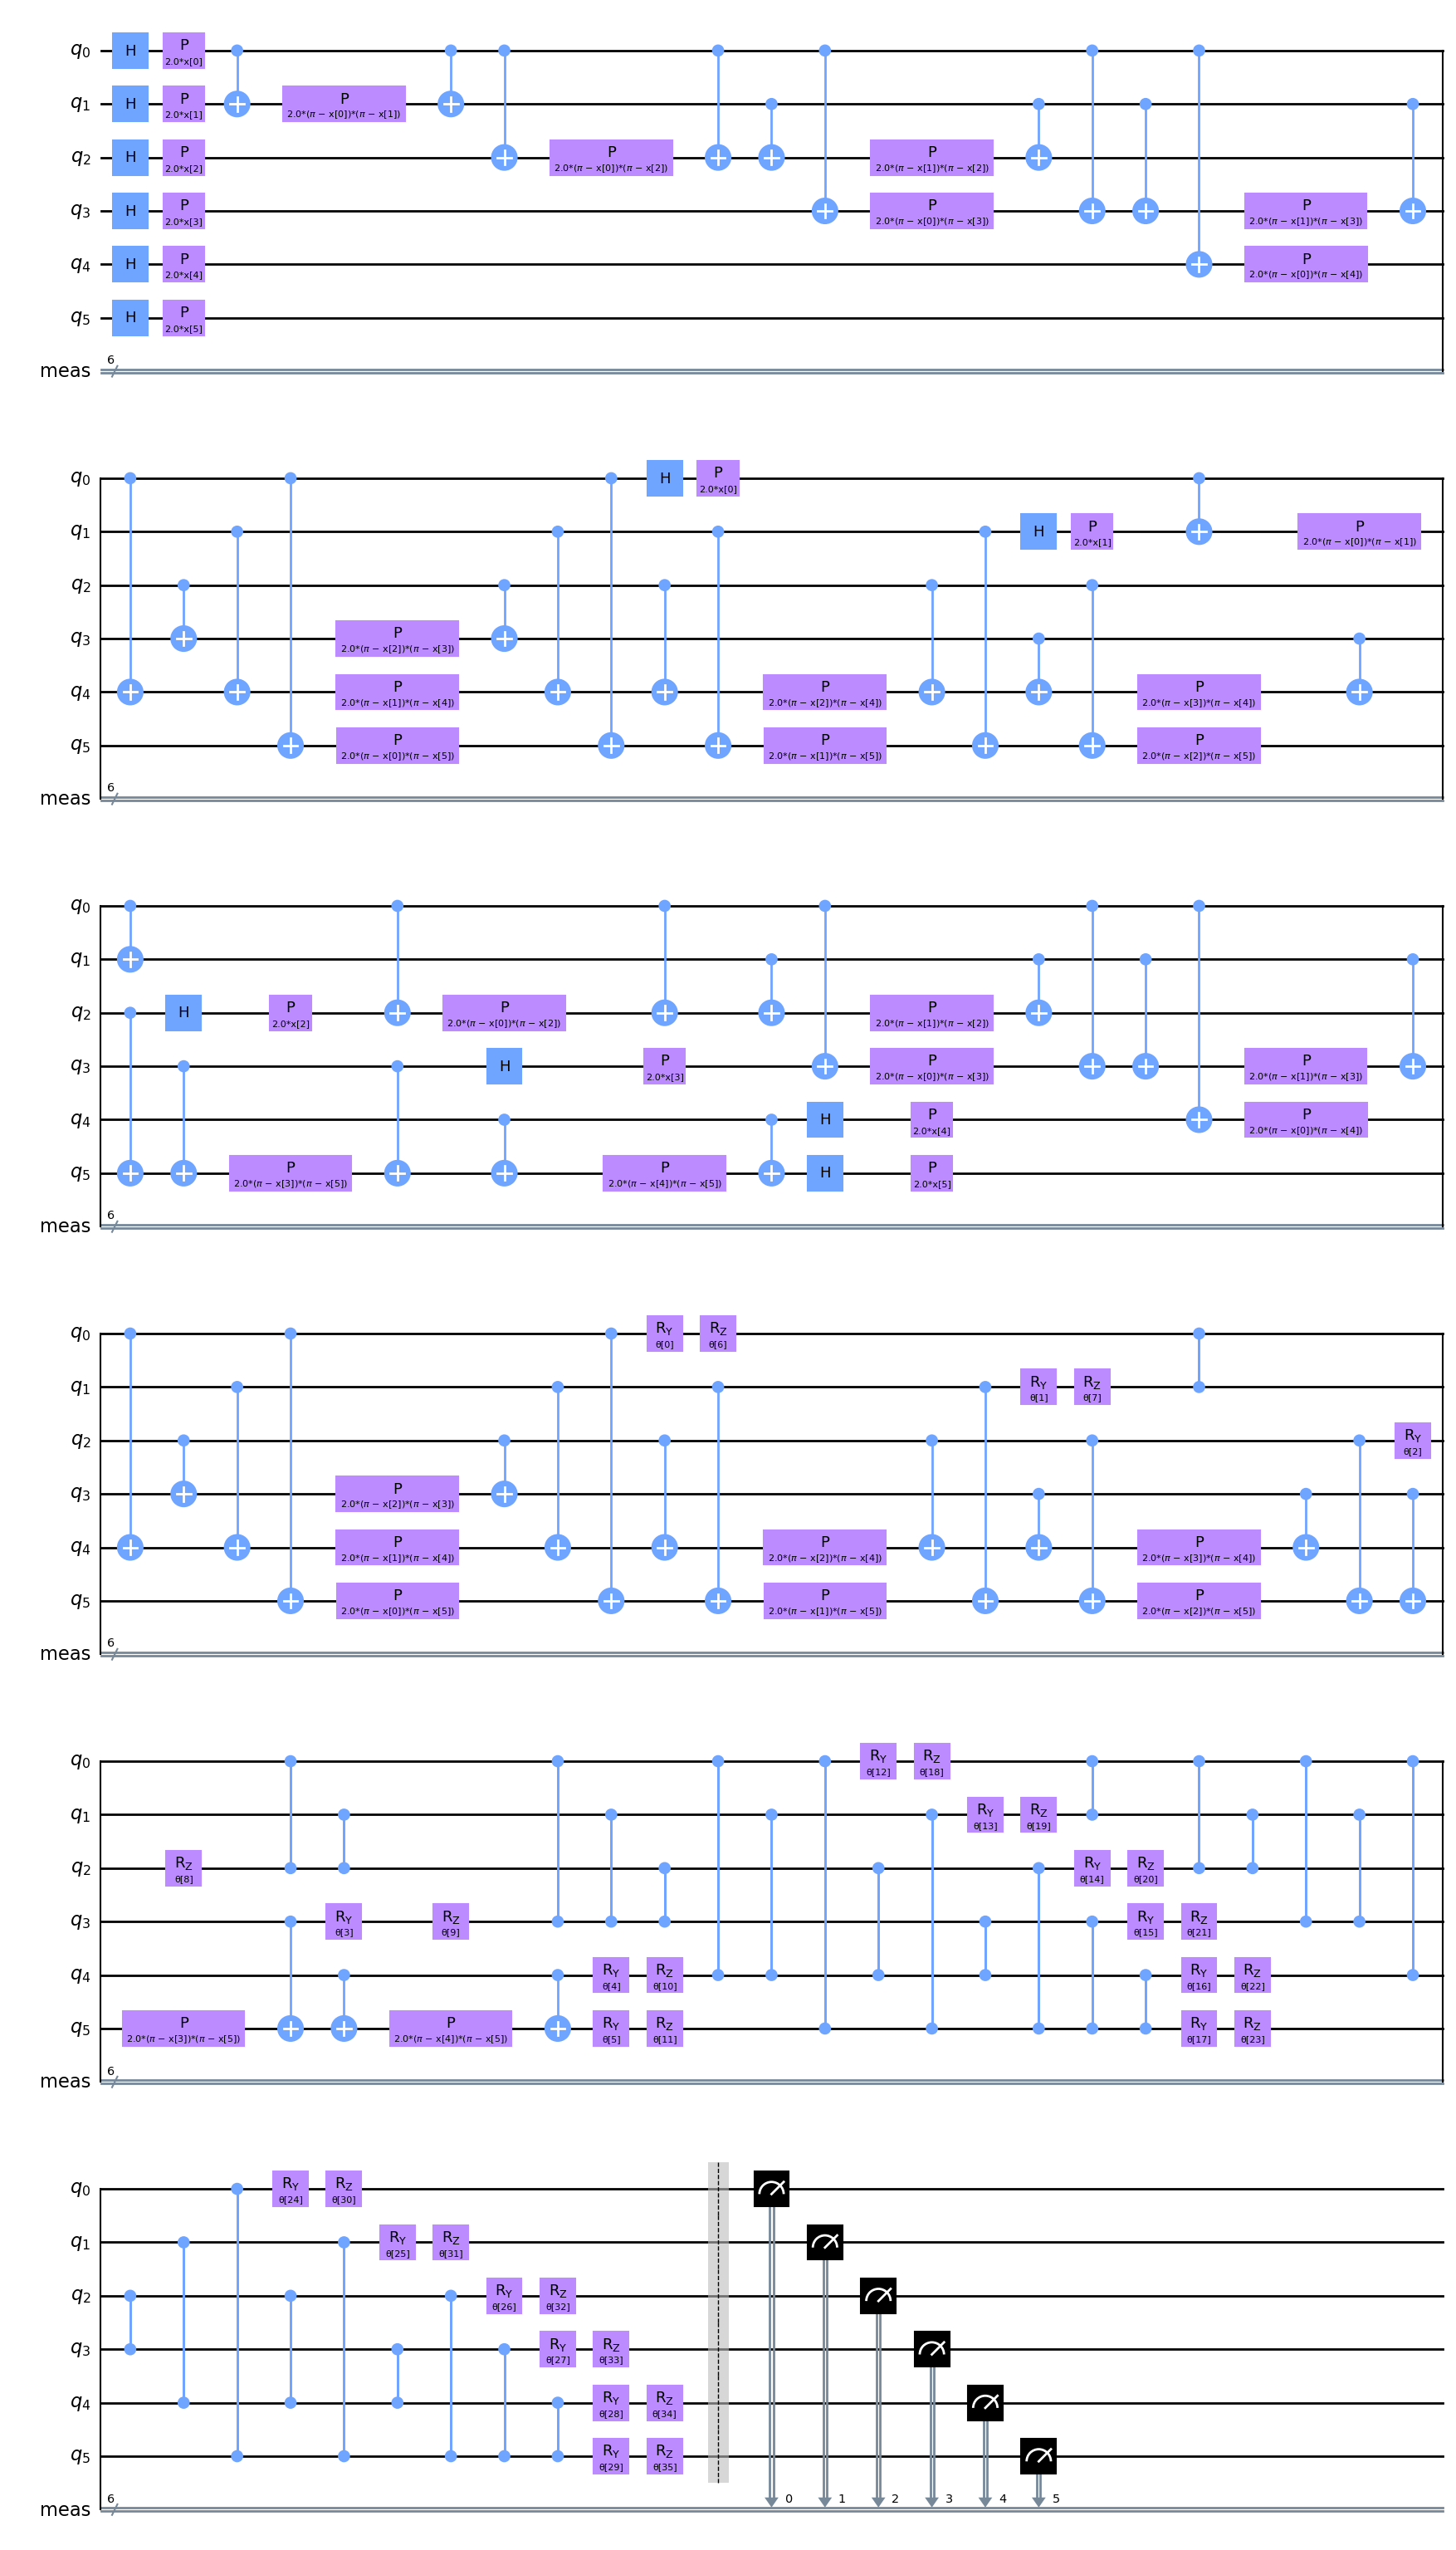

In [14]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=6, reps=2)
VAR_FORM = TwoLocal(6, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

In [15]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [16]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

In [17]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [18]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    # print(type(classification))
    return classification

In [19]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    # print(p)
    return -np.log(p + 1e-10)



def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        ind = labels[i]
        cost += cross_entropy_loss(classification, ind[0])
    cost /= len(data)
    return cost

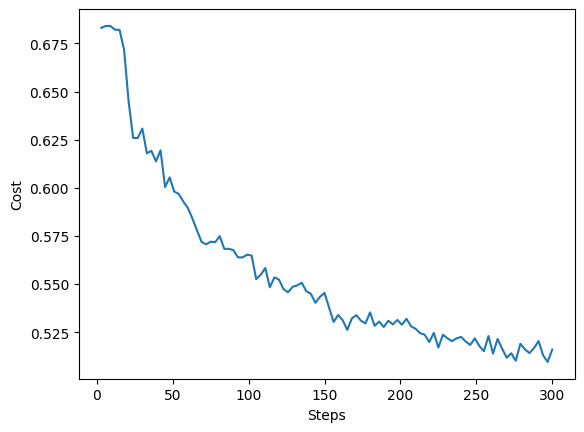

In [20]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.random.random(VAR_FORM.num_parameters)
# initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
#                           0.88372228, 4.08885928, 2.45568528,
#                           4.92364593, 5.59032015, 3.66837805,
#                           4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)
  
# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [21]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

0.6

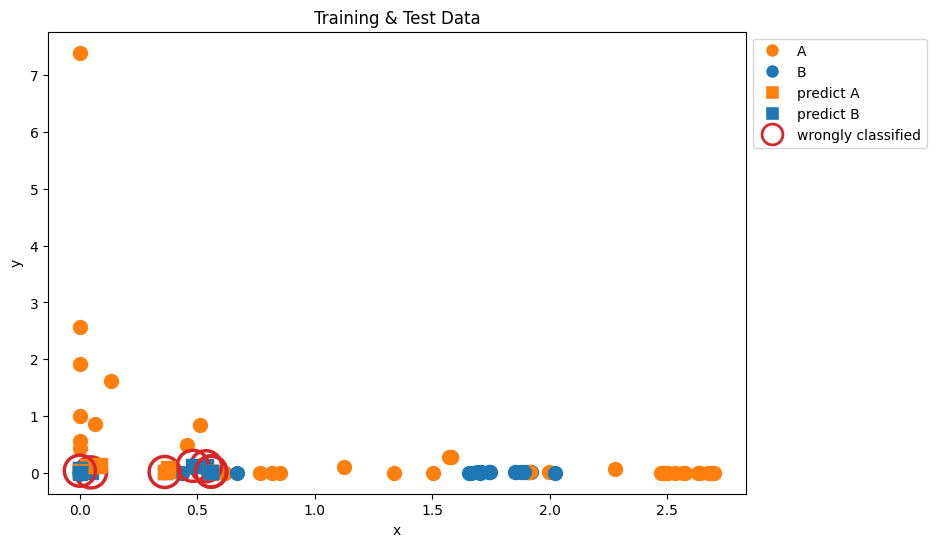

In [28]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plot.png')

plt.show()

In [29]:
f1,f2,f3 = TEST_DATA, TEST_LABELS, predictions

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()


In [31]:
initial_point = np.random.random(VAR_FORM.num_parameters)
# initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
#                           0.96566328, 0.38243769, 0.90403094,
#                           0.82271449, 0.26810137, 0.61076489,
#                           0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

/tmp/ipykernel_60/1333675911.py:9: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


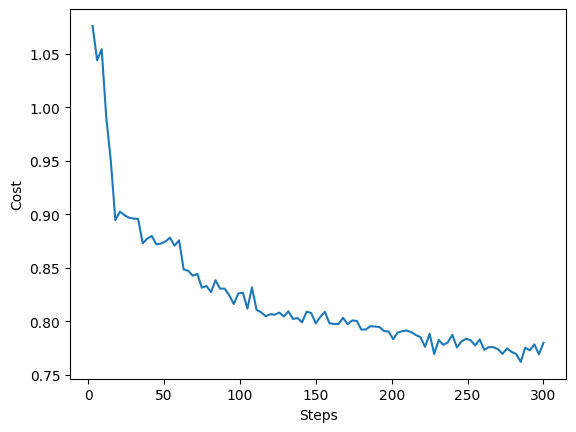

In [32]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [33]:
# score == accuracy
vqc.score(TEST_DATA, test_labels_oh)

0.4

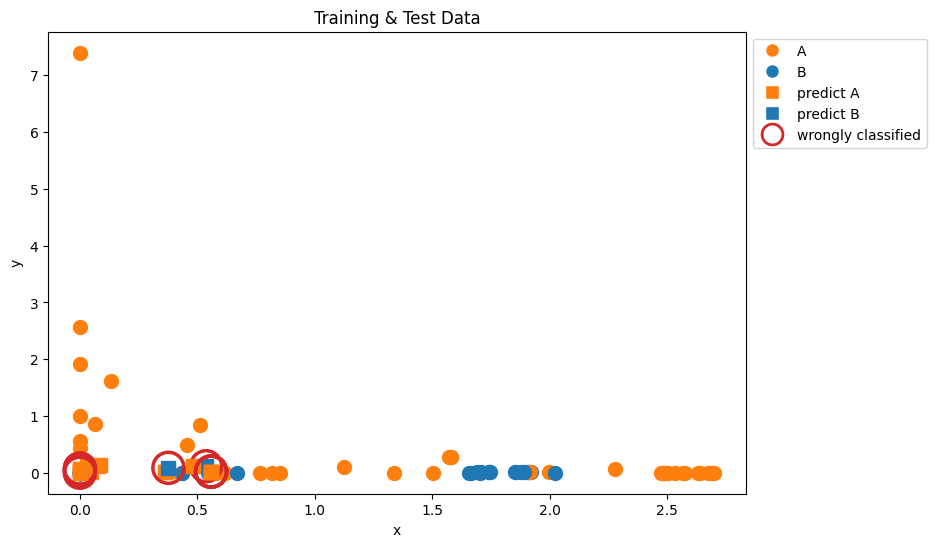

In [34]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(TEST_DATA, test_labels_oh,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig('plot1.png')


plt.show()